## Importing the required libiraries

In [ ]:
pip install wordcloud

In [ ]:
pip install nltk

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import roc_curve, auc

## Importing the dataset

In [17]:
df = pd.read_csv(
    "SMSSpamCollection.csv",
    sep="\t",
    header=None,
    names=["label", "message"],
    encoding="utf-8"
)

In [18]:
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Data Exploration

#### Class Distribution

In [19]:
df['label'].value_counts().unique()

array([4825,  747])

In [20]:
df['label'].value_counts(normalize=True) * 100

label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

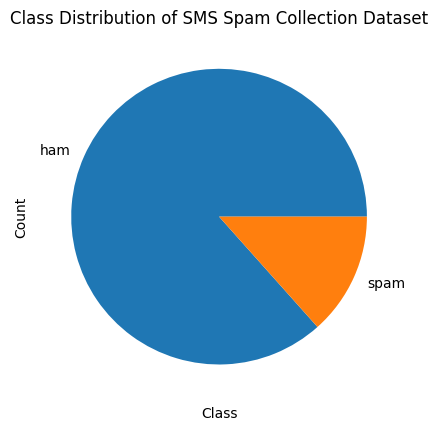

In [21]:
df['label'].value_counts().plot(kind='pie')
plt.title("Class Distribution of SMS Spam Collection Dataset")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#### Message length based on Labels

In [22]:
df['message_length'] = df['message'].apply(len)

df.groupby('label')['message_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0
spam,747.0,138.670683,28.873603,13.0,133.0,149.0,157.0,223.0


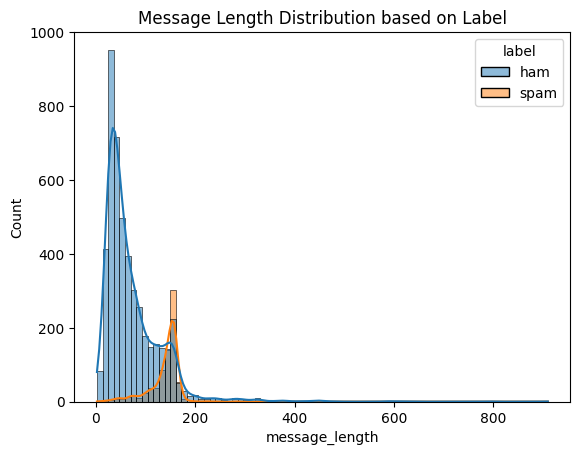

In [23]:
sns.histplot(data=df, x='message_length', hue='label', bins=80, kde=True)
plt.title("Message Length Distribution based on Label")
plt.show()

#### Word Counts Based on Labels

In [24]:
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

df.groupby('label')['word_count'].mean()

label
ham     14.310259
spam    23.911647
Name: word_count, dtype: float64

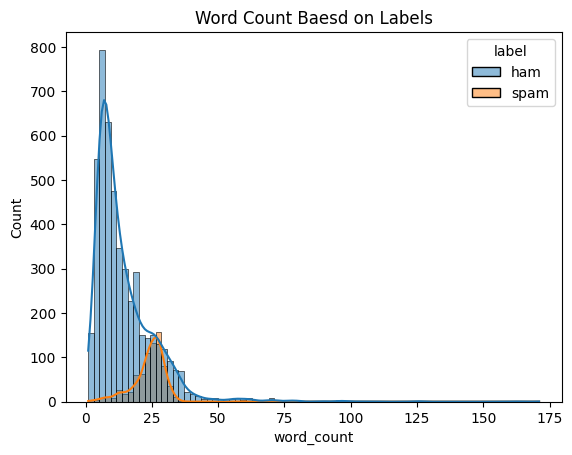

In [25]:
sns.histplot(data=df, x='word_count', hue='label', bins=80, kde=True)

plt.title("Word Count Baesd on Labels")
plt.show()

In [26]:
from collections import Counter
spam_words = Counter(" ".join(df[df['label']=='spam']['message']).split()).most_common(10)
ham_words = Counter(" ".join(df[df['label']=='ham']['message']).split()).most_common(10)

print("most common words in spam messages: ", spam_words)
print ("most common words in ham messages: ", ham_words)

most common words in spam messages:  [('to', 607), ('a', 360), ('your', 187), ('call', 185), ('or', 185), ('the', 178), ('2', 169), ('for', 169), ('you', 164), ('is', 143)]
most common words in ham messages:  [('to', 1538), ('you', 1462), ('I', 1439), ('the', 1029), ('a', 977), ('i', 742), ('and', 739), ('in', 736), ('u', 651), ('is', 645)]


### Word Cloud

In [27]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df['clean_message'] = df['message'].apply(clean_text)

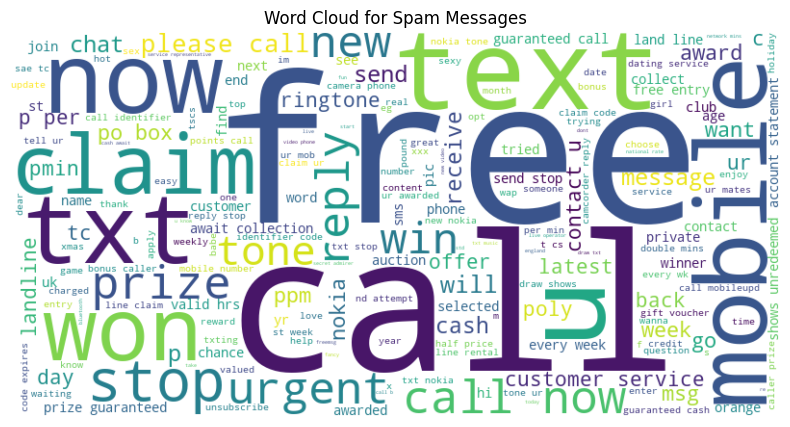

In [28]:
ham_text = " ".join(df[df['label'] == 'spam']['clean_message'])

ham_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(ham_text)

plt.figure(figsize=(10,5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Spam Messages")
plt.show()

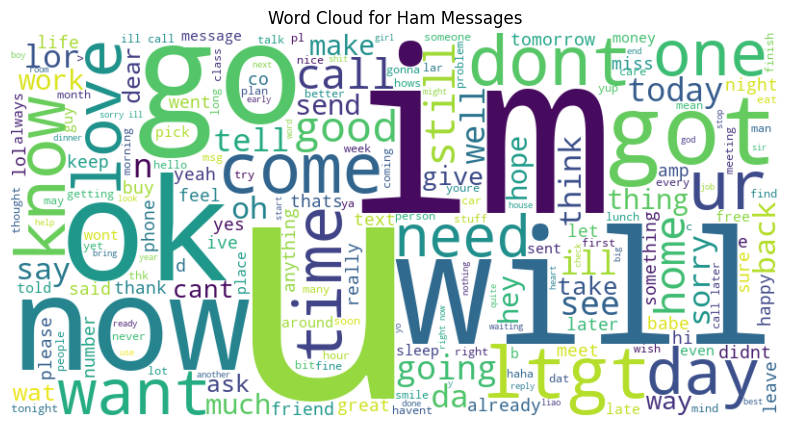

In [29]:
ham_text = " ".join(df[df['label'] == 'ham']['clean_message'])

ham_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(ham_text)

plt.figure(figsize=(10,5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Ham Messages")
plt.show()

### Text Preprocessing

#### Downloading requied nltk 

In [49]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [50]:
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]
    return " ".join(tokens)

df['processed_message'] = df['message'].apply(preprocess)
df['processed_message']

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts may...
3                     u dun say early hor u c already say
4                     nah think go usf life around though
                              ...                        
5567    time tried contact u pound prize claim easy ca...
5568                          ü b going esplanade fr home
5569                                 pity mood suggestion
5570    guy bitching acted like interested buying some...
5571                                       rofl true name
Name: processed_message, Length: 5572, dtype: object

### Feature Extraction

In [51]:
vectorizer = TfidfVectorizer(max_features=3000)

X = vectorizer.fit_transform(df['processed_message'])
y = df['label'].map({'ham': 0, 'spam': 1})

In [52]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 38677 stored elements and shape (5572, 3000)>

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### Model Training

In [100]:
class LinearSVM:
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        y_ = np.where(y == 1, 1, -1)

        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

    def decision_function(self, X):
        return np.dot(X, self.w) + self.b

In [ ]:
svm = LinearSVM()
svm.fit(X_train.toarray(), y_train.values)
svm_preds = svm.predict(X_test.toarray())
svm_preds = np.where(svm_preds == -1, 0, 1)

#### SVM Model Evaluation

In [64]:
print(classification_report(y_test, svm_preds))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

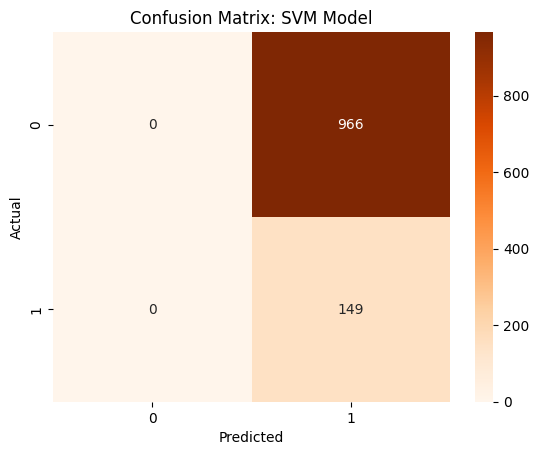

In [92]:
svm1_cm = confusion_matrix(y_test, svm_preds)

sns.heatmap(svm1_cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: SVM Model")
plt.show()

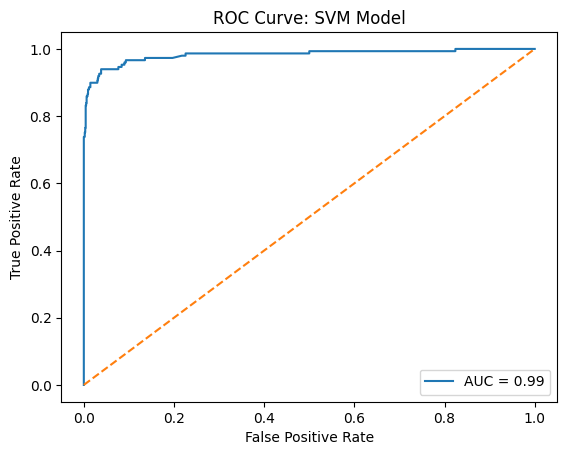

In [ ]:
svm_scores = svm.decision_function(X_test.toarray())

fpr, tpr, thresholds = roc_curve(y_test, svm_scores)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: SVM Model")
plt.legend()
plt.show()

### Ensemble Learning

#### Logistic Regression

In [65]:
lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    C=1.0,
    solver='liblinear'
)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

#### Naive Bayes

In [66]:
nb = MultinomialNB(alpha=1.0)
nb.fit(X_train, y_train)
nb_preds = nb.predict(X_test)

#### Combining Model results

In [67]:
lr_prob = lr.predict_proba(X_test)[:,1]
nb_prob = nb.predict_proba(X_test)[:,1]

final_prob = (0.6 * lr_prob) + (0.4 * nb_prob)
ensemble_preds = (final_prob >= 0.5).astype(int)

#### Ensemble Models Evaluation

In [68]:
print("Logistic Regression")
print(classification_report(y_test, lr_preds))

Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.91      0.92      0.92       149

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [69]:
print("Naive Bayes")
print(classification_report(y_test, nb_preds))

Naive Bayes
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       0.98      0.82      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [70]:
print("Ensemble Model")
print(classification_report(y_test, ensemble_preds))

Ensemble Model
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



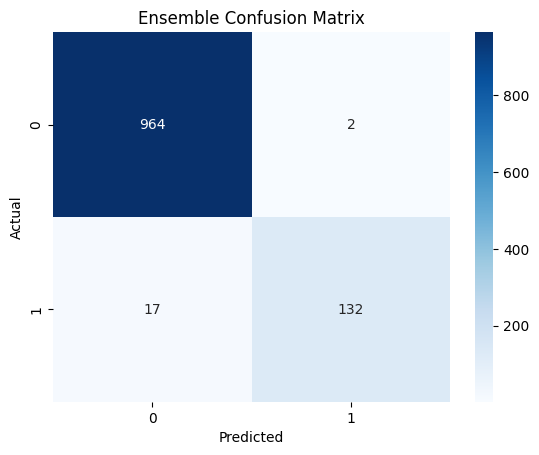

In [71]:
sns.heatmap(confusion_matrix(y_test, ensemble_preds),
            annot=True, fmt='d', cmap='Blues')
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

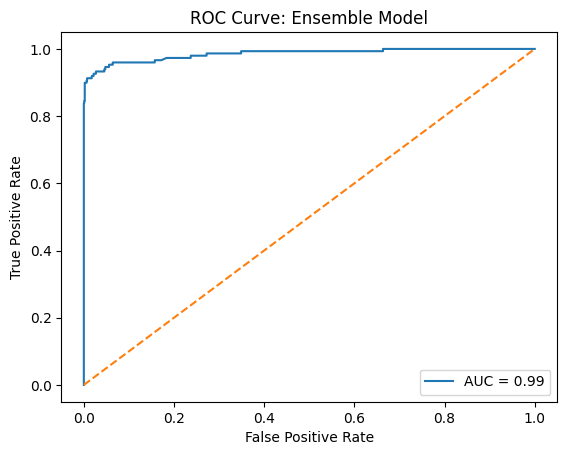

In [ ]:
fpr, tpr, _ = roc_curve(y_test, final_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Ensemble Model")
plt.legend()
plt.show()

### Retraining SVM to handle Class Imbalance (Failed attempt)

In [72]:
def compute_class_weights(y):
    counter = Counter(y)
    total = len(y)
    class_weights = {
        cls: total / (len(counter) * count)
        for cls, count in counter.items()
    }
    return class_weights

class_weights = compute_class_weights(y_train.values)
print(class_weights)

{np.int64(0): 0.577481212749417, np.int64(1): 3.7265886287625416}


In [79]:
class ImbalancedLinearSVM:
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs

    def fit(self, X, y, class_weights):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        # Convert labels: {0,1} → {-1,+1}
        y_ = np.where(y == 1, 1, -1)

        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                weight = class_weights[y[idx]]
                condition = y_[idx] * (np.dot(x_i, self.w) + self.b) >= 1

                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (
                        2 * self.lambda_param * self.w - weight * y_[idx] * x_i
                    )
                    self.b -= self.lr * weight * y_[idx]

    def predict(self, X):
        linear_output = np.dot(X, self.w) + self.b
        return np.sign(linear_output)

In [80]:
svm_imb = ImbalancedLinearSVM(
    lr=0.001,
    lambda_param=0.01,
    epochs=800
)

svm_imb.fit(
    X_train.toarray(),
    y_train.values,
    class_weights
)

#### Retrained SVM evaluation

In [82]:
revised_svm_preds = svm_imb.predict(X_test.toarray())
revised_svm_preds = np.where(revised_svm_preds == -1, 0, 1)

print(classification_report(y_test, revised_svm_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       966
           1       0.13      1.00      0.24       149

    accuracy                           0.13      1115
   macro avg       0.07      0.50      0.12      1115
weighted avg       0.02      0.13      0.03      1115



C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f